In [16]:
import pandas as pd
import geopandas as gpd
import numpy as np
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

Populating the interactive namespace from numpy and matplotlib


In [17]:
road_merge = pd.read_pickle('road_merge.pickle')

In [18]:
road_merge[~road_merge['TotalVol'].isnull()].head()

,TotalVol,centroid,geometry,name,set,x,y
y,,,,,,,
2.775622e+06,310431.000,POINT (303136.7666760656 2775621.887421818),LINESTRING (303195.0455006739 2775885.16319138...,中山南北路,"(基河路, 小北街)",303136.766676,NaN
2.776187e+06,240295.000,POINT (303227.938516076 2776187.235380104),LINESTRING (303234.0590565056 2776491.16083247...,中山南北路,"(中正路, 小北街)",303227.938516,NaN
2.777540e+06,209187.875,POINT (302945.993934618 2777540.131702279),LINESTRING (302949.3103567673 2777673.66629230...,中山南北路,"(德行東西路, 忠誠路)",302945.993935,NaN
2.777967e+06,137684.000,POINT (302993.588100909 2777966.832806859),LINESTRING (302949.9123668254 2777673.79029815...,中山南北路,"(士東路, 德行東西路)",302993.588101,NaN
2.778627e+06,55071.000,POINT (303245.6300697403 2778627.282765958),LINESTRING (303052.8347356209 2778252.62793530...,中山南北路,"(士東路, 天母東路)",303245.630070,NaN


In [19]:
del road_merge['y']

In [20]:
road_merge = road_merge.reset_index()

In [21]:
accident_102y_twd97_poi = pd.read_csv('./20151114 Accident/102y_twd97.csv')
accident_102y_twd97 = pd.read_csv('./20151114 Accident/102y.csv')

In [22]:
accident_102y_twd97['Alcohol'] = accident_102y_twd97['Alcohol'].apply(lambda t: t-1)

In [23]:
accident_102y_twd97_poi.columns

Index(['CASE_NO', 'IEOK_01', 'ACCD_TP', 'Year', 'x_coord', 'y_coord'], dtype='object')

In [24]:
x = accident_102y_twd97_poi.groupby(by='CASE_NO')['x_coord'].mean()

In [25]:
y = accident_102y_twd97_poi.groupby(by='CASE_NO')['y_coord'].mean()

In [26]:
是否飲酒 = accident_102y_twd97.groupby(by='CASE_NO')['Alcohol'].sum()

In [27]:
accident_102y_twd97 = pd.DataFrame({
        'x_coord': x,
        'y_coord': y,
        '是否飲酒': 是否飲酒
    })

In [28]:
accident_102y_twd97.head(1)

,x_coord,y_coord,是否飲酒
C5103031,300360.4423,2773118.614,0.0


In [29]:
accident_102y_twd97 = accident_102y_twd97.dropna()

In [30]:
import shapely

In [31]:
accident_102y_twd97['geometry'] = accident_102y_twd97[['x_coord', 'y_coord']].apply(
    lambda t: shapely.geometry.Point(t[0], t[1]), axis=1
)

In [32]:
accident_102y_twd97 = gpd.GeoDataFrame(accident_102y_twd97)

In [35]:
accident_102y_twd97 = accident_102y_twd97[accident_102y_twd97['是否飲酒'] == 0]


In [36]:
# accident_102y_twd97.plot()

In [37]:
len(accident_102y_twd97)

14053

In [38]:
sample = accident_102y_twd97.sample(4022)

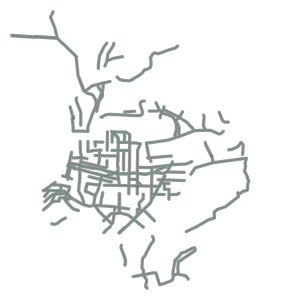

In [21]:
road_merge.unary_union.buffer(40)

In [39]:
sample_in_buffer = sample[sample.intersects(road_merge.unary_union.buffer(40))]

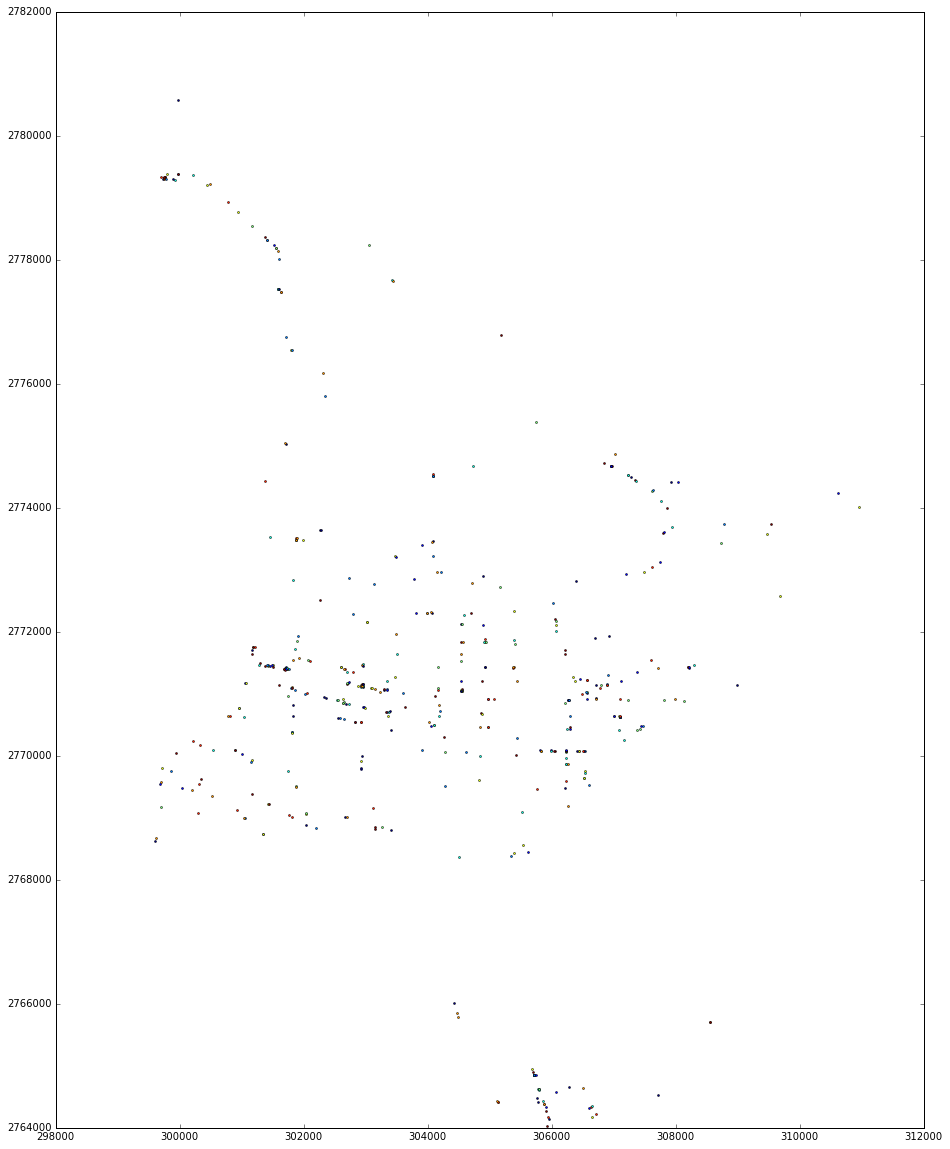

In [40]:
sample_in_buffer.plot()

In [41]:
road_df = road_merge.copy()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/geopandas-0.1.0.dev_320b75d-py3.4.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


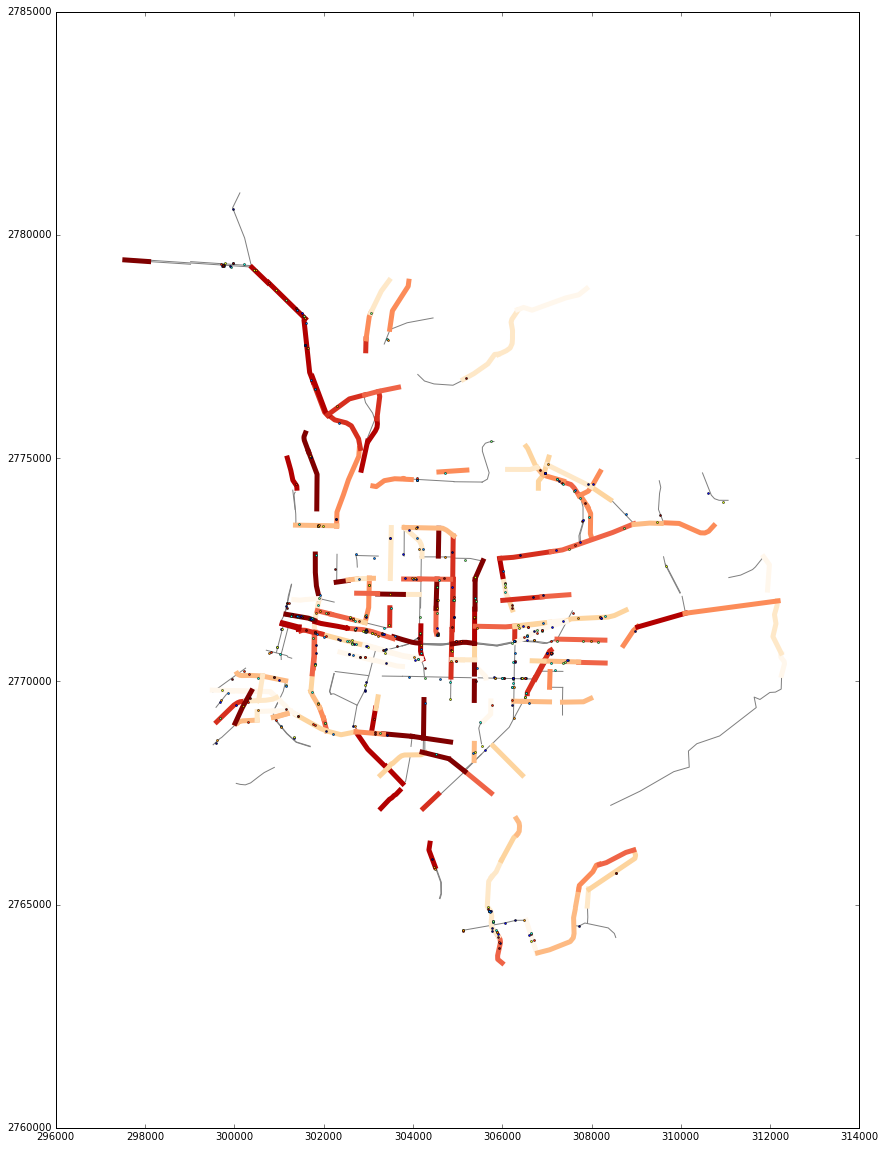

In [42]:
ax = road_df[road_df['TotalVol'].isnull()].plot(color='gray')
road_df[~road_df['TotalVol'].isnull()].plot(column='TotalVol', scheme='QUANTILES', k=9, colormap='OrRd', linewidth=5, ax=ax)
sample_in_buffer.plot(ax=ax)

In [43]:
from geopandas.tools import sjoin

In [40]:
road_merge['road_id'] = road_merge.index

In [47]:
def f(geometry):
    geometry_x = gpd.GeoSeries(geometry[0])
    geometry_y = gpd.GeoSeries(geometry[1])
    return geometry_x.intersection(geometry_y).length

poi_buffer = sample_in_buffer.copy()
poi_buffer['geometry'] = sample_in_buffer.geometry.buffer(40)
poi_buffer = poi_buffer.reset_index()
road_in_bufer = sjoin(road_merge, poi_buffer)
# road_in_bufer.columns
road_in_bufer = pd.merge(road_in_bufer, poi_buffer, left_on='index', right_on='index')
# road_in_bufer
road_in_bufer['length'] = road_in_bufer[['geometry_x', 'geometry_y']].apply(f, axis=1)

In [48]:
road_in_length_total = pd.DataFrame(road_in_bufer.groupby('index', as_index=False)['length'].sum())

In [49]:
road_in_bufer = pd.merge(road_in_bufer, road_in_length_total, left_on='index', right_on='index')

In [50]:
road_in_bufer['len_part'] = road_in_bufer['length_x'] / road_in_bufer['length_y']

In [55]:
road_accident_count = pd.DataFrame(road_in_bufer.groupby(['name', 'set'])['len_part'].sum())

In [56]:
road_accident_count = road_accident_count.rename(columns={'len_part': 'acc_count'})

In [57]:
road_accident_count = road_accident_count.reset_index()

In [59]:
road_merge = pd.merge(road_merge, road_accident_count, on=['name', 'set'])

In [60]:
road_merge = gpd.GeoDataFrame(road_merge)

In [61]:
road_df = road_merge

In [62]:
road_df.head()

,y,TotalVol,centroid,geometry,name,set,x,acc_count
0,2.772698e+06,NaN,POINT (302742.5029817595 2772697.772613008),LINESTRING (302721.8132723004 2772833.68083906...,中山南北路,"(民權東西路, 錦州街)",302742.502982,1.000000
1,2.777967e+06,137684.0,POINT (302993.588100909 2777966.832806859),LINESTRING (302949.9123668254 2777673.79029815...,中山南北路,"(士東路, 德行東西路)",302993.588101,0.630287
2,2.778627e+06,55071.0,POINT (303245.6300697403 2778627.282765958),LINESTRING (303052.8347356209 2778252.62793530...,中山南北路,"(士東路, 天母東路)",303245.630070,0.369713
3,2.768969e+06,NaN,POINT (301154.8908642664 2768969.345910037),LINESTRING (300996.6603272418 2769579.03017621...,中華路,"(和平東西路, 水源路)",301154.890864,1.490406
4,2.768977e+06,NaN,POINT (301158.0189772808 2768977.442067221),LINESTRING (301698.9484797145 2768547.59077903...,中華路,"(和平東西路, 泉州街)",301158.018977,3.509594


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/geopandas-0.1.0.dev_320b75d-py3.4.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


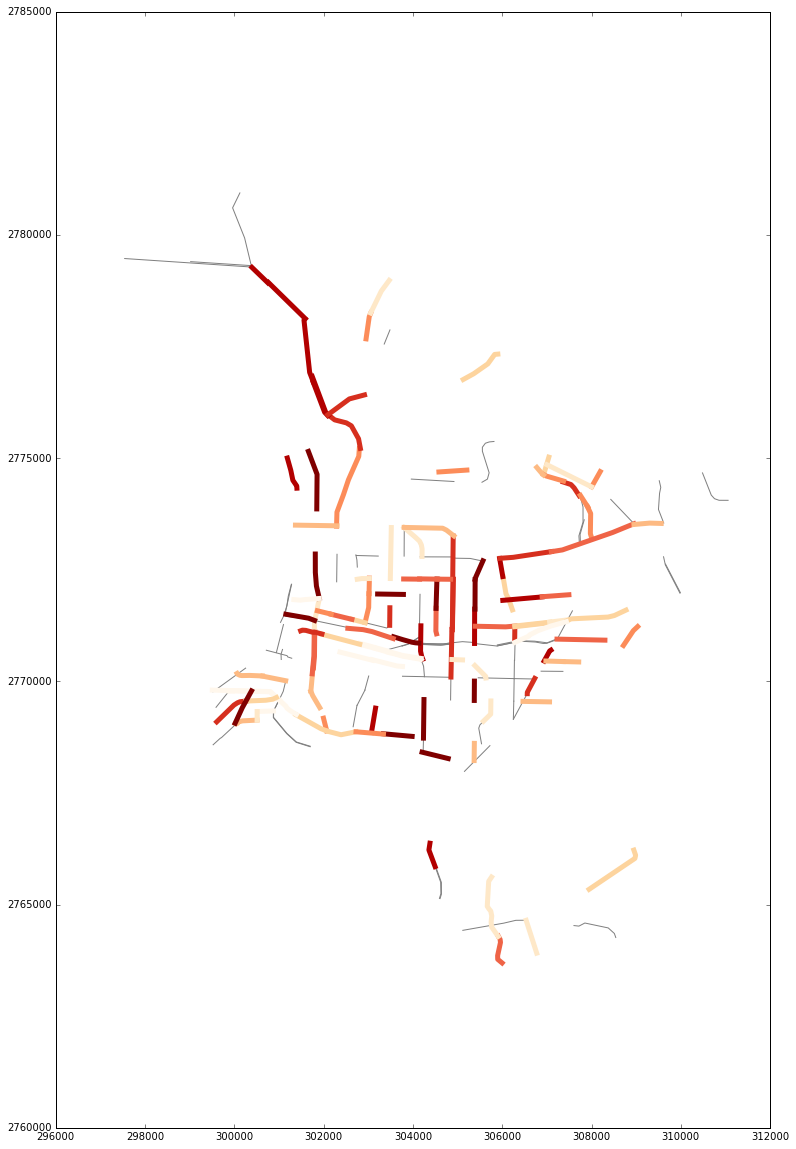

In [63]:
ax = road_df[road_df['TotalVol'].isnull()].plot(color='gray')
road_df[~road_df['TotalVol'].isnull()].plot(column='TotalVol', scheme='QUANTILES', k=9, colormap='OrRd', linewidth=5, ax=ax)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/geopandas-0.1.0.dev_320b75d-py3.4.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


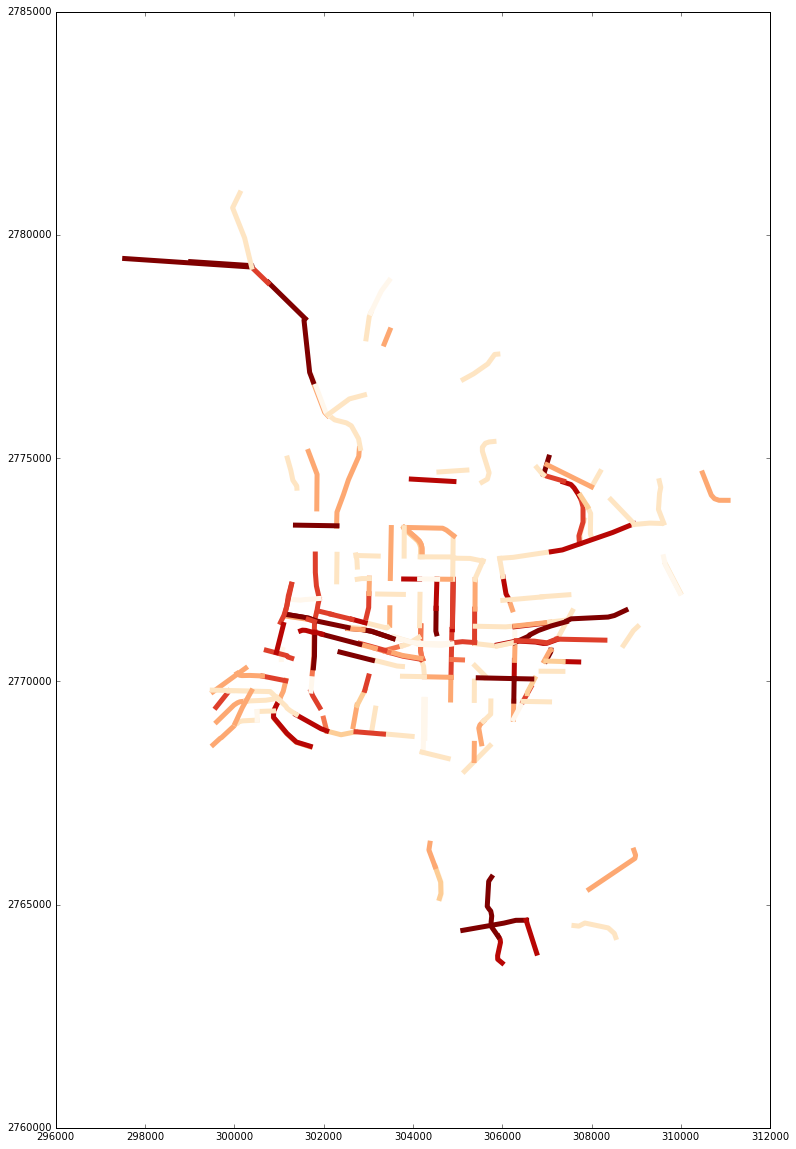

In [64]:
ax = road_df[road_df['acc_count'].isnull()].plot(color='gray')
road_df[~road_df['acc_count'].isnull()].plot(column='acc_count', scheme='QUANTILES', k=9, colormap='OrRd', linewidth=5, ax=ax)

In [65]:
road_df['p'] = road_df['acc_count'] / (road_df['TotalVol']/10*10)  / road_df.length

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/geopandas-0.1.0.dev_320b75d-py3.4.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


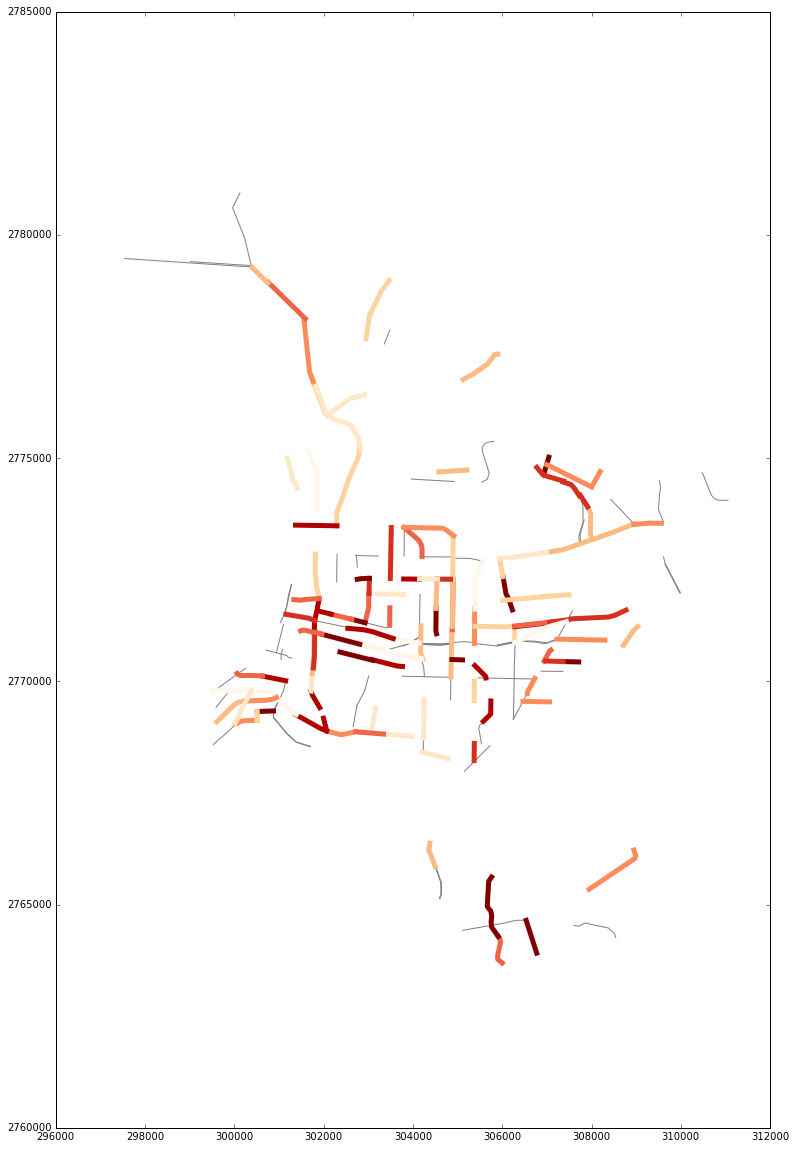

In [66]:
ax = road_df[road_df['p'].isnull()].plot(color='gray')
road_df[~road_df['p'].isnull()].plot(column='p', scheme='QUANTILES', k=9, colormap='OrRd', linewidth=5, ax=ax)

In [67]:
road_df_cen = road_df.copy()

In [68]:
road_df_cen.geometry = road_df_cen.centroid

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/geopandas-0.1.0.dev_320b75d-py3.4.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


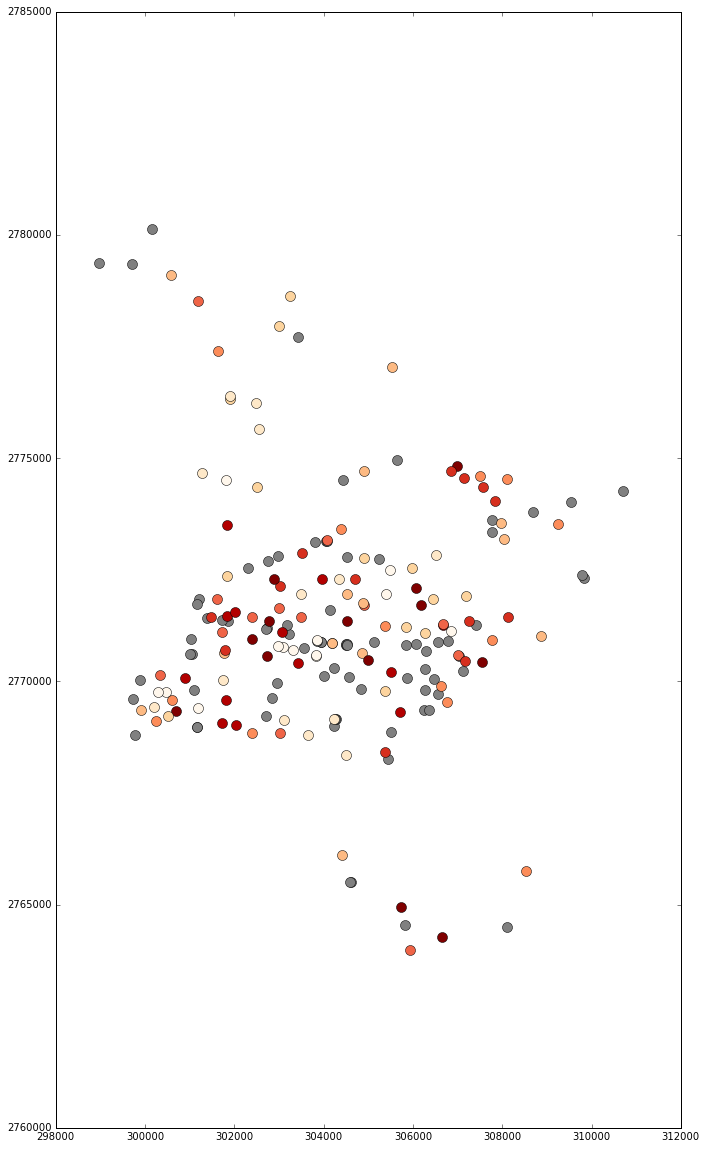

In [69]:
ax = road_df_cen[road_df_cen['p'].isnull()].plot(color='gray', markersize=10)
road_df_cen[~road_df_cen['p'].isnull()].plot(column='p', scheme='QUANTILES', k=9, colormap='OrRd', markersize=10,ax=ax)

In [70]:
road_df_cen.to_pickle('road_df_cen_無酒駕.pickle')